# Read NASA Ames data file format to acces EBC data from Alert
http://proj.badc.rl.ac.uk/svn/ndg/nappy/trunk/doc/USAGE.txt

Data acquired from global aerosol database. Pb sampled data is available for a longer period of time than EBC. The overlapping data years are 1989-1992. Pb sampled weekly, EBC measured every hour.

In [20]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import nappy
import datetime
import calendar
from matplotlib.dates import date2num
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy.signal import correlate
from scipy.stats import pearsonr, spearmanr

In [2]:
BC_file1 = 'BC_Alert_1989-2013/1989'
BC_file2 = 'BC_Alert_1989-2013/1990'
BC_file3 = 'BC_Alert_1989-2013/1991'
BC_file4 = 'BC_Alert_1989-2013/1992'
Pb_file1 = 'Pb_Alert_1980-1995/1989'
Pb_file2 = 'Pb_Alert_1980-1995/1990'
Pb_file3 = 'Pb_Alert_1980-1995/1991'
Pb_file4 = 'Pb_Alert_1980-1995/1992'
folder = '/data/brogalla/atmospheric/'

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Black Carbon data:

In [4]:
def load_BC_data(filename,folder=folder):
    var = nappy.openNAFile(folder+filename)
    var.readData()
    data_V = var.V
    data_V_np = np.array(data_V)

    BC_date = data_V_np[0,:]
    BC_conc = data_V_np[1,:] #ug/m3    
    
    # create array of dates
    list_dates = [datetime.timedelta(days=BC_date[i]) for i in range(0,len(BC_date))]
    year       = var.DATE[0]
    month      = var.DATE[1]
    day        = var.DATE[2]
    ref_date   = datetime.datetime(year, month, day)
    dates      = [ref_date + list_dates[j] for j in range(0,len(list_dates))]
    return dates, BC_conc

BC.getVariable(3)

In [5]:
dates_BC_1989, BC_1989 = load_BC_data(BC_file1)
dates_BC_1990, BC_1990 = load_BC_data(BC_file2)
dates_BC_1991, BC_1991 = load_BC_data(BC_file3)
dates_BC_1992, BC_1992 = load_BC_data(BC_file4)

## Pb data:

In [6]:
def load_Pb_data(filename,folder=folder):
    var = nappy.openNAFile(folder+filename)
    var.readData()
    data_V = var.V
    data_V_np = np.array(data_V)
    
    Pb_date = data_V_np[0,:]
    Pb_conc = data_V_np[5,:] #ng/m3

    # create array of dates
    list_dates = [datetime.timedelta(days=Pb_date[i]) for i in range(0,len(Pb_date))]
    year       = var.DATE[0]
    month      = var.DATE[1]
    day        = var.DATE[2]
    ref_date   = datetime.datetime(year, month, day)
    dates      = [ref_date + list_dates[j] for j in range(0,len(list_dates))]
    return dates, Pb_conc

In [7]:
dates_Pb_1989, Pb_1989 = load_Pb_data(Pb_file1)
dates_Pb_1990, Pb_1990 = load_Pb_data(Pb_file2)
dates_Pb_1991, Pb_1991 = load_Pb_data(Pb_file3)
dates_Pb_1992, Pb_1992 = load_Pb_data(Pb_file4)

# Look at relation:

In [8]:
pltPb_dates_1989 = date2num(dates_Pb_1989)
pltPb_dates_1990 = date2num(dates_Pb_1990)
pltPb_dates_1991 = date2num(dates_Pb_1991)
pltPb_dates_1992 = date2num(dates_Pb_1992)

Text(0,0.5,'Lead (ng/m3)')

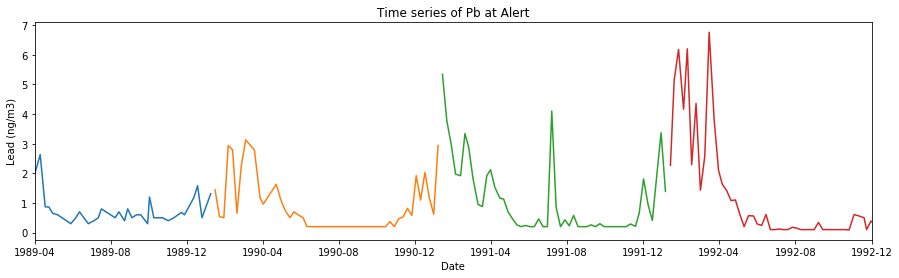

In [9]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltPb_dates_1989, Pb_1989,'-')
ax1.plot_date(pltPb_dates_1990, Pb_1990,'-')
ax1.plot_date(pltPb_dates_1991, Pb_1991,'-')
ax1.plot_date(pltPb_dates_1992, Pb_1992,'-')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of Pb at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lead (ng/m3)')

In [10]:
pltBC_dates_1989 = date2num(dates_BC_1989)
pltBC_dates_1990 = date2num(dates_BC_1990)
pltBC_dates_1991 = date2num(dates_BC_1991)
pltBC_dates_1992 = date2num(dates_BC_1992)

In [11]:
BC_1989_ma = np.ma.masked_greater(BC_1989, 2)
BC_1990_ma = np.ma.masked_greater(BC_1990, 2)
BC_1991_ma = np.ma.masked_greater(BC_1991, 2)
BC_1992_ma = np.ma.masked_greater(BC_1992, 2)

Text(0,0.5,'Equivalent black carbon (ug/m3)')

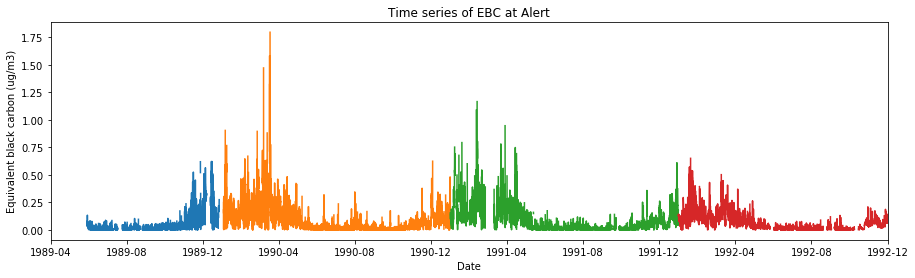

In [12]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltBC_dates_1989, BC_1989_ma, '-')
ax1.plot_date(pltBC_dates_1990, BC_1990_ma, '-')
ax1.plot_date(pltBC_dates_1991, BC_1991_ma, '-')
ax1.plot_date(pltBC_dates_1992, BC_1992_ma, '-')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of EBC at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equivalent black carbon (ug/m3)')

In [13]:
BC_1989_ma.shape

(5192,)

Append time series:

In [14]:
BC_ma = np.concatenate([BC_1989_ma,BC_1990_ma, BC_1991_ma, BC_1992_ma])
BC_dates = np.concatenate([dates_BC_1989, dates_BC_1990, dates_BC_1991, dates_BC_1992])

In [15]:
BC_masked = np.ma.masked_greater(BC_ma, 2)

In [16]:
Pb_ma = np.concatenate([Pb_1989, Pb_1990, Pb_1991, Pb_1992])
Pb_dates = np.concatenate([dates_Pb_1989, dates_Pb_1990, dates_Pb_1991, dates_Pb_1992])

Remove masked elements for BC to calculate running average:

In [17]:
EBC = BC_masked[~BC_masked.mask]
EBC_dates = BC_dates[~BC_masked.mask]

### save to NetCDF file:

In [24]:
# Setup the new NetCDF file:
ncd = nc.Dataset('Alert_1989-1992.nc', 'w', zlib=True)
#nc_tools.init_dataset_attrs(
#    ncd,
#    title='Concentrations measured',
#    notebook_name='read NASA ames',
#    nc_filepath='./read_NASA_ames.nc',
#    comment='Converted from NASA ames file format')

ncd.createDimension('time_Pb',len(Pb_dates))
ncd.createDimension('time_EBC',len(EBC_dates))

<type 'netCDF4._netCDF4.Dimension'>: name = 'time_EBC', size = 24435

In [25]:
# variables
Pb_var = ncd.createVariable('Pb', 'float64', ('time_Pb'))
Pb_var.units = 'ng/m3'
Pb_var.long_name = 'Aerosol Pb concentration'  
Pb_var.coordinates = 'time_Pb'
Pb_var[:] = Pb_ma

# variables
Pb_var = ncd.createVariable('Pb_dates', 'float64', ('time_Pb'))
Pb_var.units = 'date2num(datetime)'
Pb_var.long_name = 'Aerosol collection dates'  
Pb_var.coordinates = 'time_Pb'
Pb_var[:] = date2num(Pb_dates)

EBC_var = ncd.createVariable('EBC', 'float64', ('time_EBC'))
EBC_var.units = 'ug/m3'
EBC_var.long_name = 'Aerosol EBC concentration'  
EBC_var.coordinates = 'time_EBC'
EBC_var[:] = EBC

EBC_var = ncd.createVariable('EBC_dates', 'float64', ('time_EBC'))
EBC_var.units = 'date2num(datetime)'
EBC_var.long_name = 'Aerosol collection dates'  
EBC_var.coordinates = 'time_EBC'
EBC_var[:] = date2num(EBC_dates)

In [26]:
ncd.close()

### continue calculation:

Take running average of Pb and EBC time series:

In [19]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [20]:
Pb_ave = smooth(Pb_ma, window_len=10, window='flat')
EBC_ave = smooth(EBC, window_len=1000, window='flat')

In [21]:
Pb_ave.shape

(208,)

In [22]:
EBC_ave.shape

(25434,)

Text(0,0.5,'Lead (ng/m3)')

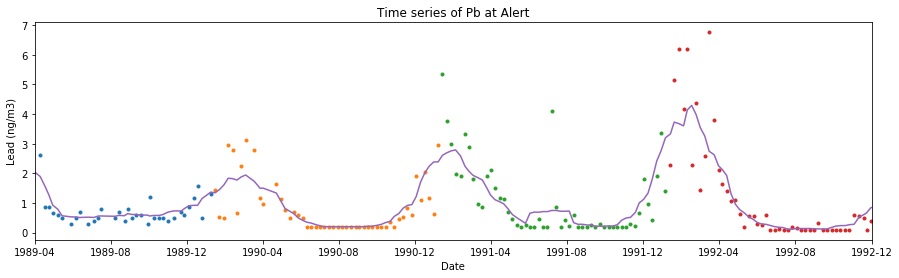

In [23]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltPb_dates_1989, Pb_1989,'.')
ax1.plot_date(pltPb_dates_1990, Pb_1990,'.')
ax1.plot_date(pltPb_dates_1991, Pb_1991,'.')
ax1.plot_date(pltPb_dates_1992, Pb_1992,'.')
ax1.plot_date(date2num(Pb_dates), Pb_ave[5:204],'-')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of Pb at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lead (ng/m3)')

Text(0,0.5,'Equivalent black carbon (ug/m3)')

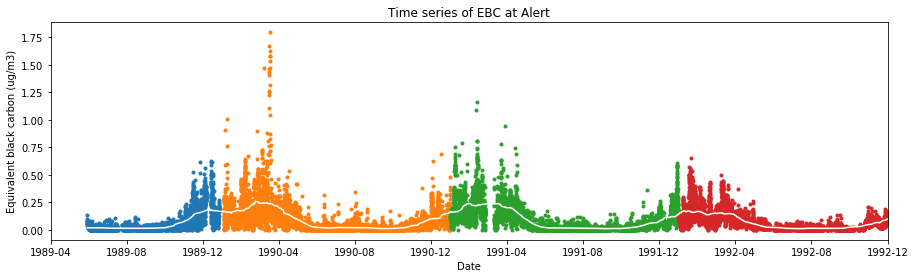

In [24]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltBC_dates_1989, BC_1989_ma, '.')
ax1.plot_date(pltBC_dates_1990, BC_1990_ma, '.')
ax1.plot_date(pltBC_dates_1991, BC_1991_ma, '.')
ax1.plot_date(pltBC_dates_1992, BC_1992_ma, '.')
ax1.plot_date(date2num(EBC_dates), EBC_ave[500:24935],'-w')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of EBC at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equivalent black carbon (ug/m3)')

Interpolate running averages onto time grid:

In [25]:
base = EBC_dates[0]
diff = (EBC_dates[-1] - base)
time_grid = [base + datetime.timedelta(days=x) for x in range(0, diff.days)] # interpolated to daily values 

In [26]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [27]:
t1_EBC = np.array([toTimestamp(t) for t in EBC_dates])
t1_Pb = np.array([toTimestamp(t) for t in Pb_dates])
EBC = EBC_ave[500:24935]
Pb = Pb_ave[5:204]

EBC_grid = np.interp([toTimestamp(t) for t in time_grid], t1_EBC, EBC)
Pb_grid = np.interp([toTimestamp(t) for t in time_grid], t1_Pb, Pb)

In [28]:
time_grid[945]

datetime.datetime(1991, 12, 30, 16, 59, 59, 971200)

In [29]:
Pb_grid1989 = Pb_grid[0:216]
Pb_grid1990 = Pb_grid[216:581]
Pb_grid1991 = Pb_grid[581:946]
Pb_grid1992 = Pb_grid[946:-1]

In [30]:
EBC_grid1989 = EBC_grid[0:216]
EBC_grid1990 = EBC_grid[216:581]
EBC_grid1991 = EBC_grid[581:946]
EBC_grid1992 = EBC_grid[946:-1]

Dispersion relation between running averages:

Text(0.5,0,'Equivalent black carbon (ug/m3)')

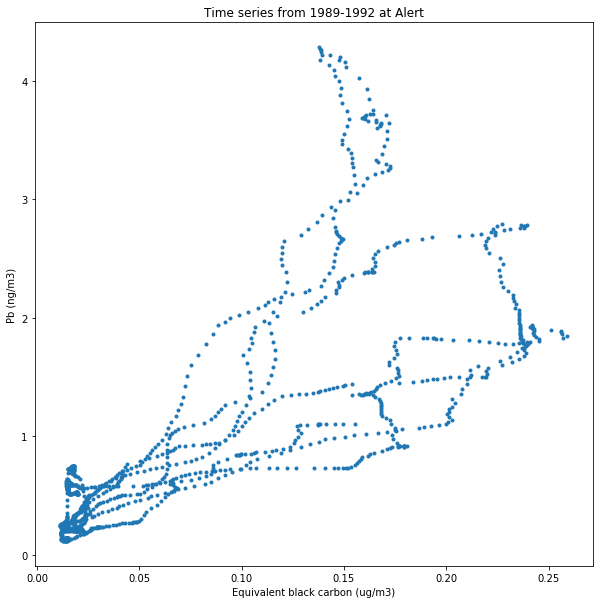

In [31]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_grid, Pb_grid, '.')
ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb (ng/m3)')
ax1.set_xlabel('Equivalent black carbon (ug/m3)')

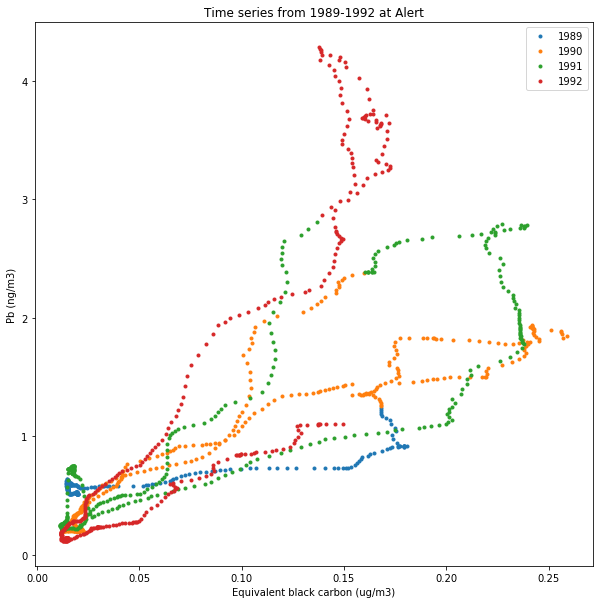

In [32]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_grid1989, Pb_grid1989,  '.', label='1989')
ax1.plot(EBC_grid1990, Pb_grid1990, '.', label='1990')
ax1.plot(EBC_grid1991, Pb_grid1991,  '.', label='1991')
ax1.plot(EBC_grid1992, Pb_grid1992, '.', label='1992')
ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb (ng/m3)')
ax1.set_xlabel('Equivalent black carbon (ug/m3)')
ax1.legend()

In [58]:
print 'Pearson r value: ', pearsonr(EBC_grid, Pb_grid)

Pearson r value:  (0.7552878805460123, 1.2088448117965375e-242)


In [59]:
print 'Pearson r value: ', spearmanr(EBC_grid, Pb_grid) # rank correlation

Pearson r value:  SpearmanrResult(correlation=0.840380224338268, pvalue=0.0)


### Different method: fourier transform for a bandpass filter

In [33]:
W = rfftfreq(EBC.size, d=(EBC_dates[1]-EBC_dates[0]).total_seconds())
f_signal = rfft(EBC)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W>3e-7)] = 0
cut_f_signal[(W<0)] = 0

EBC_filtered = irfft(cut_f_signal)

In [34]:
f_signal

array([ 2.17005988e+03, -1.30033081e+02, -1.86501519e+02, ...,
       -1.25901646e-04, -6.80874746e-02, -2.26927560e-04])

In [35]:
dt = (EBC_dates[1]-EBC_dates[0]).total_seconds()
amp = np.fft.rfft(EBC)
freqs = np.fft.rfftfreq(EBC.size,dt)

phase = (np.arctan2(amp.imag,amp.real))

(0, 600)

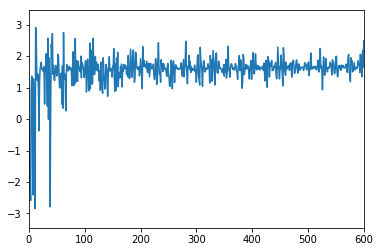

In [36]:
plt.plot(phase)
plt.xlim([0, 600])

(-1e-09, 5e-07)

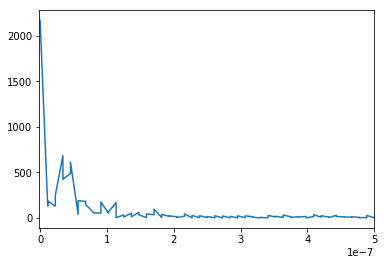

In [37]:
plt.plot(W, np.abs(f_signal))
plt.xlim([-1e-9,5e-7])

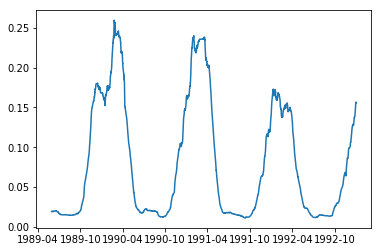

In [38]:
plt.plot(EBC_dates,EBC)

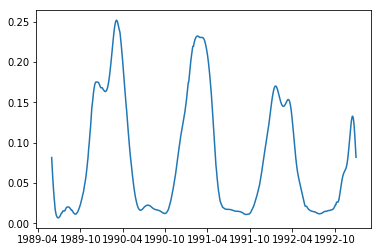

In [39]:
plt.plot(EBC_dates,EBC_filtered)

Text(0,0.5,'Equivalent black carbon (ug/m3)')

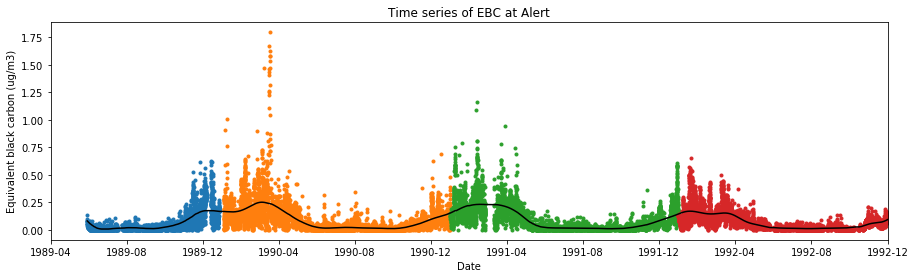

In [40]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltBC_dates_1989, BC_1989_ma, '.')
ax1.plot_date(pltBC_dates_1990, BC_1990_ma, '.')
ax1.plot_date(pltBC_dates_1991, BC_1991_ma, '.')
ax1.plot_date(pltBC_dates_1992, BC_1992_ma, '.')
ax1.plot_date(date2num(EBC_dates), EBC_filtered,'-k')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of EBC at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equivalent black carbon (ug/m3)')

In [41]:
W_Pb = rfftfreq(Pb_ma.size, d=(Pb_dates[1]-Pb_dates[0]).total_seconds())
f_signal_Pb = rfft(Pb_ma)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal_Pb = f_signal_Pb.copy()
cut_f_signal_Pb[(W_Pb > 1e-7)] = 0
cut_f_signal_Pb[(W_Pb < 0)] = 0

Pb_filtered = irfft(cut_f_signal_Pb)

In [42]:
amp_Pb = np.fft.rfft(Pb_ma)
freqs_Pb = np.fft.rfftfreq(Pb_ma.size,dt)

phase_Pb = (np.arctan2(amp_Pb.imag,amp_Pb.real))

(0, 100)

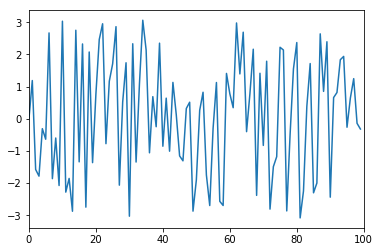

In [43]:
plt.plot(phase_Pb)
plt.xlim([0, 100])

In [44]:
print np.average(phase)
print np.average(phase_Pb)

2.2848341374147747
0.09825358123533878


(-1e-08, 5e-07)

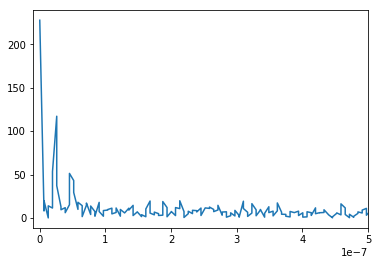

In [45]:
plt.plot(W_Pb, np.abs(f_signal_Pb))
plt.xlim([-1e-8,5e-7])

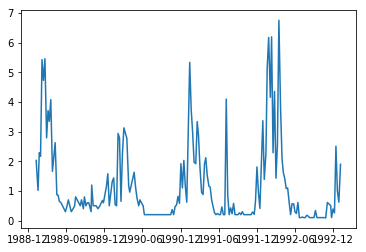

In [46]:
plt.plot(Pb_dates,Pb_ma)

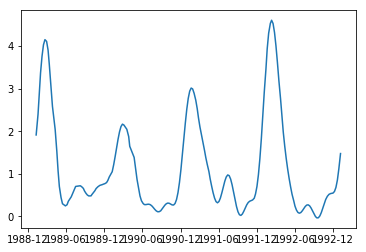

In [47]:
plt.plot(Pb_dates,Pb_filtered)

Text(0,0.5,'Lead (ng/m3)')

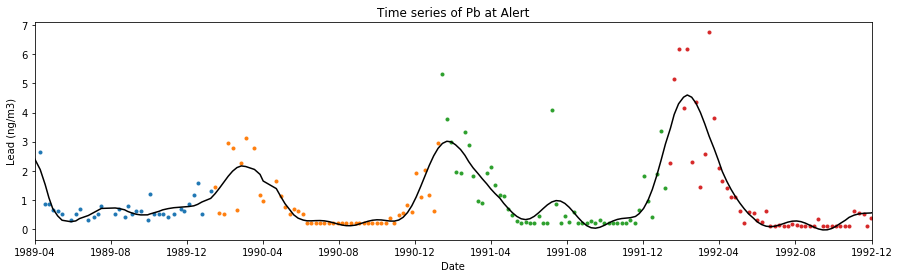

In [48]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(pltPb_dates_1989, Pb_1989,'.')
ax1.plot_date(pltPb_dates_1990, Pb_1990,'.')
ax1.plot_date(pltPb_dates_1991, Pb_1991,'.')
ax1.plot_date(pltPb_dates_1992, Pb_1992,'.')
ax1.plot_date(date2num(Pb_dates), Pb_filtered,'-k')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of Pb at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lead (ng/m3)')

Now interpolate to the same dates:

In [49]:
base = EBC_dates[0]
diff = (EBC_dates[-1] - base)
time_grid = [base + datetime.timedelta(days=x) for x in range(0, diff.days)] # interpolated to daily values 

In [50]:
t1_EBC = np.array([toTimestamp(t) for t in EBC_dates])
t1_Pb = np.array([toTimestamp(t) for t in Pb_dates])

EBC_filtered_grid = np.interp([toTimestamp(t) for t in time_grid], t1_EBC, EBC_filtered)
Pb_filtered_grid = np.interp([toTimestamp(t) for t in time_grid], t1_Pb, Pb_filtered)

And plot the dispersion relation:

Text(0.5,0,'Equivalent black carbon (ug/m3)')

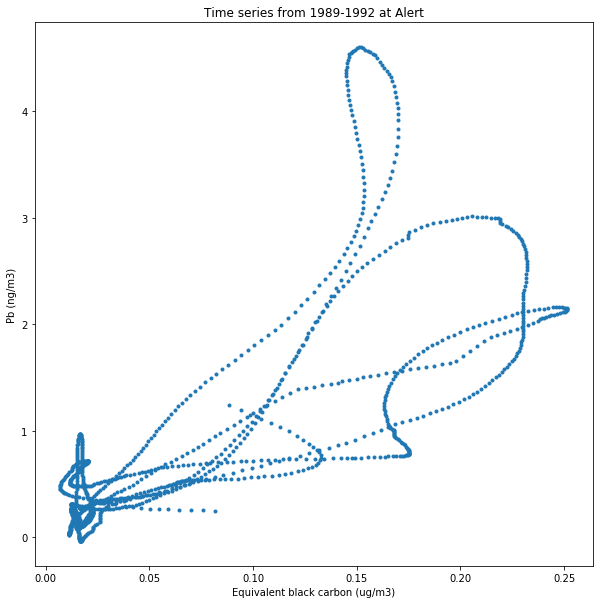

In [51]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_filtered_grid, Pb_filtered_grid, '.')
ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb (ng/m3)')
ax1.set_xlabel('Equivalent black carbon (ug/m3)')

In [54]:
print 'Pearson r value: ', pearsonr(EBC_filtered_grid, Pb_filtered_grid)

Pearson r value:  (0.7445086686079635, 3.966234286869478e-232)


In [57]:
print 'Pearson r value: ', spearmanr(EBC_filtered_grid, Pb_filtered_grid) # rank correlation

Pearson r value:  SpearmanrResult(correlation=0.7940249022519469, pvalue=1.7761497409081088e-285)
